<a href="https://colab.research.google.com/github/khangtictoc/CTF-Writeup-Competition/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

---

## Import used library


In [ ]:
# from google.colab import drive
# drive.mount("/content/gdrive")

In [ ]:
# for data
import pandas as pd
import numpy as np
# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
# for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
# for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
!pip install lime
# for explainer
from lime import lime_tabular




## Open "train.csv" file for demo


In [ ]:
dtf = pd.read_csv('train.csv') 
dtf.head() # Display DataFrame

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data Analysis

---

## Define Columns Whether be Categories or Number Type





In [ ]:
'''
Recognize whether a column is numerical or categorical.
:parameter
    :param dtf: dataframe - input data
    :param col: str - name of the column to analyze
    :param max_cat: num - max number of unique values to recognize a column as categorical
:return
    "cat" if the column is categorical or "num" otherwise
'''
def utils_recognize_type(dtf, col, max_cat=20):
    if (dtf[col].dtype is object) | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

# Testing
print(utils_recognize_type(dtf, "Parch"))
print(utils_recognize_type(dtf, "Age"))
print(utils_recognize_type(dtf, "Survived"))

## Show missing-value Chart

---



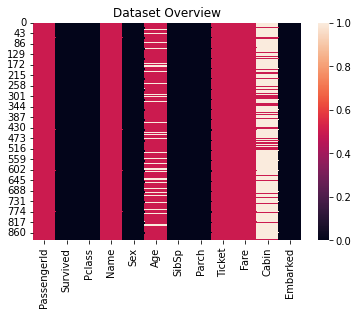

 Categerocial   Numeric   NaN 


In [ ]:
dic_cols = {col:utils_recognize_type(dtf, col, max_cat=20) for col in dtf.columns}
heatmap = dtf.isnull() # isnull DataFrame
for k,v in dic_cols.items():
 if v == "num":
   heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1) # 'num' columns
 else:
   heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1) # 'cat' columns
   
sns.heatmap(heatmap, cbar=True).set_title('Dataset Overview') # Create heatmap
plt.show() # Show heatmap
# Print colorized ouput onto terminal
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

## Setup columns 



In [ ]:
dtf = dtf.set_index("PassengerId") # Set index for "PassengerId"
dtf = dtf.rename(columns={"Survived":"Y"}) # Rename column "Survived" to "Y"

## Bar Plot (Y Column)




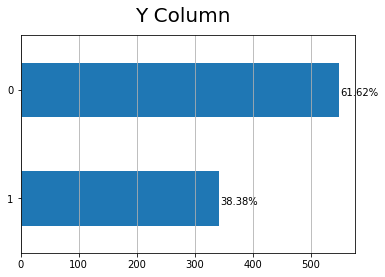

In [ ]:
y = "Y"
ax = dtf[y].value_counts().sort_values().plot(kind="barh")
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals) # Sum all rectangle's width
for i in ax.patches:
     ax.text(i.get_width()+ 1, i.get_y()+.20, # Alignment for text's display
     str(round((i.get_width()/total)*100, 2))+'%', # Calculate proportion and get 2-digit precision
     fontsize=10, color='black') # Style for text's display
     
ax.grid(axis="x") # Add grid line
plt.suptitle(y + " Column", fontsize=20)
plt.show()

## Box plot (Age Column)



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


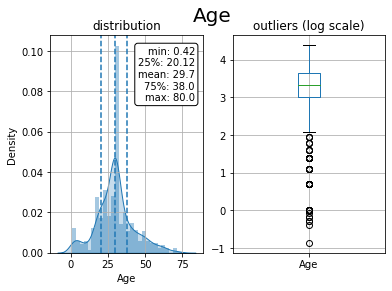

In [ ]:
x = "Age"
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)
### distribution plot
ax[0].title.set_text('distribution')
variable = dtf[x].fillna(dtf[x].mean()) # Fill null value in DataFrame with average number (mean()) of that column
breaks = np.quantile(variable, q=np.linspace(0, 1, 11)) # Define quantiles with 10 even parts
variable = variable[ (variable > breaks[0]) & (variable < breaks[10]) ] # Make sure variable is in range of calculated quantile
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = dtf[x].describe() # Include statistics's info

# Add broken lines
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True) # Enable ruler (gridline)
des = round(des, 2).apply(lambda x: str(x)) # Round each values in Series with 2-digit precision and convert to string

### Create a box of statistics 's info
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))

### boxplot 
ax[1].title.set_text('outliers (log scale)')
tmp_dtf = pd.DataFrame(dtf[x])
tmp_dtf[x] = np.log(tmp_dtf[x])
tmp_dtf.boxplot(column=x, ax=ax[1])
plt.show()

# Feature Engineering

---

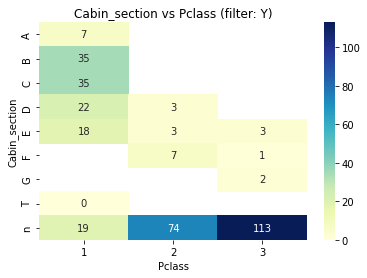

In [ ]:
## Create new column
dtf["Cabin_section"] = dtf["Cabin"].apply(lambda x: str(x)[0])
## Plot contingency table
cont_table = pd.crosstab(index=dtf["Cabin_section"], 
             columns=dtf["Pclass"], values=dtf["Y"], aggfunc="sum")
sns.heatmap(cont_table, annot=True, cmap="YlGnBu", fmt='.0f').set_title('Cabin_section vs Pclass (filter: Y)' )
plt.show()

# Preprocessing
---

## Split and randomize data

In [ ]:
## split data
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.3)

## print info
print("X_train shape:", dtf_train.drop("Y",axis=1).shape, "| X_test shape:", dtf_test.drop("Y",axis=1).shape)
print("y_train mean:", round(np.mean(dtf_train["Y"]),2), "| y_test mean:", round(np.mean(dtf_test["Y"]),2))
print(dtf_train.shape[1], "features:", dtf_train.drop("Y",axis=1).columns.to_list())

X_train shape: (623, 11) | X_test shape: (268, 11)
y_train mean: 0.39 | y_test mean: 0.38
12 features: ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Cabin_section']


## Fill the N/A values with mean value

In [ ]:
dtf_train["Age"] = dtf_train["Age"].fillna(dtf_train["Age"].mean())
print(dtf_train)

             Y  Pclass                                           Name     Sex  \
PassengerId                                                                     
656          0       2                      Hickman, Mr. Leonard Mark    male   
370          1       1                  Aubart, Mme. Leontine Pauline  female   
134          1       2  Weisz, Mrs. Leopold (Mathilde Francoise Pede)  female   
65           0       1                          Stewart, Mr. Albert A    male   
890          1       1                          Behr, Mr. Karl Howell    male   
...         ..     ...                                            ...     ...   
163          0       3                     Bengtsson, Mr. John Viktor    male   
460          0       3                          O'Connor, Mr. Maurice    male   
23           1       3                    McGowan, Miss. Anna "Annie"  female   
657          0       3                          Radeff, Mr. Alexander    male   
652          1       2      

## One-hot encoding

In [ ]:
## create dummy
dummy = pd.get_dummies(dtf_train["Sex"], prefix="Sex", drop_first=True)
dtf_train= pd.concat([dtf_train, dummy], axis=1)
print( dtf_train.filter(like="Sex", axis=1).head() )

## drop the original categorical column
dtf_train = dtf_train.drop("Sex", axis=1)

                Sex  Sex_male
PassengerId                  
557          female         0
396            male         1
230          female         0
528            male         1
445            male         1


## Do similarly with "Embark"

In [ ]:
## create dummy
dummy = pd.get_dummies(dtf_train["Embarked"], prefix="Embarked",drop_first=True)
dtf_train= pd.concat([dtf_train, dummy], axis=1)
print( dtf_train.filter(like="Embarked", axis=1).head() )

## drop the original categorical column
dtf_train = dtf_train.drop("Embarked", axis=1)

            Embarked  Embarked_Q  Embarked_S
PassengerId                                 
557                C           0           0
396                S           0           1
230                S           0           1
528                S           0           1
445                S           0           1


## Do similarly with "Pclass"

In [ ]:
## create dummy
dummy = pd.get_dummies(dtf_train["Pclass"], prefix="Pclass",drop_first=True)
dtf_train= pd.concat([dtf_train, dummy], axis=1)
print( dtf_train.filter(like="Pclass", axis=1).head() )

## drop the original categorical column
dtf_train = dtf_train.drop("Pclass", axis=1)

             Pclass  Pclass_2  Pclass_3
PassengerId                            
557               1         0         0
396               3         0         1
230               3         0         1
528               1         0         0
445               3         0         1


## Remove unused columns

In [ ]:
dtf_train = dtf_train.drop([ 'Name',  'Ticket', 'Cabin',  'Cabin_section'], axis=1) # Choose columns to remove in this list
dtf_train

,Y,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,
557,1,48.0,1,0,39.6000,0,0,0,0,0
396,0,22.0,0,0,7.7958,1,0,1,0,1
230,0,NaN,3,1,25.4667,0,0,1,0,1
528,0,NaN,0,0,221.7792,1,0,1,0,0
445,1,NaN,0,0,8.1125,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
299,1,NaN,0,0,30.5000,1,0,1,0,0
214,0,30.0,0,0,13.0000,1,0,1,1,0
563,0,28.0,0,0,13.5000,1,0,1,1,0


## Rescale (MinMax-Scaler)


In [ ]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(dtf_train.drop("Y", axis=1))
dtf_scaled= pd.DataFrame(X, columns=dtf_train.drop("Y", axis=1).columns, index=dtf_train.index)
dtf_scaled["Y"] = dtf_train["Y"]
dtf_scaled.head()

,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Y
PassengerId,,,,,,,,,,
557,0.646643,0.125,0.000000,0.077294,0.0,0.0,0.0,0.0,0.0,1
396,0.293286,0.000,0.000000,0.015216,1.0,0.0,1.0,0.0,1.0,0
230,NaN,0.375,0.166667,0.049708,0.0,0.0,1.0,0.0,1.0,0
528,NaN,0.000,0.000000,0.432884,1.0,0.0,1.0,0.0,0.0,0
445,NaN,0.000,0.000000,0.015835,1.0,0.0,1.0,0.0,1.0,1


# Feature Selection

In [ ]:
corr_matrix = dtf.copy()
corr_matrix

,Y,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_section
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,n
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,n
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,n
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,n
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,B
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,n


## Remove unused columns

In [ ]:
dtf = dtf.drop(['Name', 'Ticket', 'Cabin' ], axis=1) # Choose columns to remove in this list
dtf

,Y,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_section
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,n
2,1,1,female,38.0,1,0,71.2833,C,C
3,1,3,female,26.0,0,0,7.9250,S,n
4,1,1,female,35.0,1,0,53.1000,S,C
5,0,3,male,35.0,0,0,8.0500,S,n
...,...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,13.0000,S,n
888,1,1,female,19.0,0,0,30.0000,S,B
889,0,3,female,NaN,1,2,23.4500,S,n


## Show the correlations

Text(0.5, 1.0, 'pearson correlation')

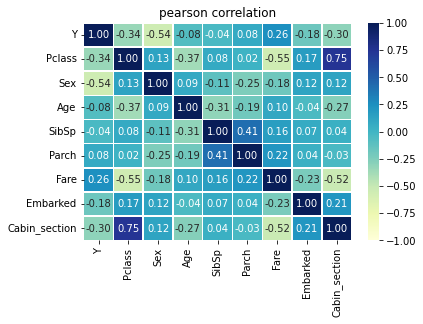

In [ ]:
corr_matrix = dtf.copy()
for col in corr_matrix.columns:
    if corr_matrix[col].dtype == "O":
         corr_matrix[col] = corr_matrix[col].factorize(sort=True)[0]
corr_matrix = corr_matrix.corr(method="pearson")
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("pearson correlation")

# Model Design

In [ ]:
## call model

model = ensemble.GradientBoostingClassifier()
## define hyperparameters combinations to try
param_dic = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],      #weighting factor for the corrections by new trees when added to the model
'n_estimators':[100,250,500,750,1000,1250,1500,1750],  #number of trees added to the model
'max_depth':[2,3,4,5,6,7],    #maximum depth of the tree
'min_samples_split':[2,4,6,8,10,20,40,60,100],    #sets the minimum number of samples to split
'min_samples_leaf':[1,3,5,7,9],     #the minimum number of samples to form a leaf
'max_features':[2,3,4,5,6,7],     #square root of features is usually a good starting point
'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]}       #the fraction of samples to be used for fitting the individual base learners. Values lower than 1 generally lead to a reduction of variance and an increase in bias.
## random search
random_search = model_selection.RandomizedSearchCV(model, 
       param_distributions=param_dic, n_iter=1000, 
       scoring="accuracy").fit(dtf_train.shape(),  dtf_test.shape())
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean accuracy:", random_search.best_score_)
model = random_search.best_estimator_

TypeError: ignored